<a href="https://colab.research.google.com/github/thdhyan/StockHack2025/blob/main/stockhack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplfinance
!pip install alpha_vantage
!pip install alpaca-py
!pip install alpaca-trade-api

In [ ]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
from tqdm import tqdm

# Replace these with your Alpaca API credentials
API_KEY = "PK4WF9YT0IMTLY2G3X7J"
API_SECRET = "ImR8gLKbsOZ0z1laPcssKtyPouD0qJeKgYFhYDYq"

# Initialize Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, base_url="https://paper-api.alpaca.markets", api_version="v2")

# Loading Data


Stocks:

Celsius Holdings, Inc. (CELH)

Carvana Co. (CVNA)

Upstart Holdings, Inc. (UPST)

Altimmune, Inc. (ALT)

FuboTV Inc. (FUBO)

In [ ]:
tickers = ['CVNA', 'CELH', 'UPST', 'ALT', 'FUBO']

tickers_matchings = {
    'CVNA': ['CVNA', 'F', 'XLE'],  # Carvana (Used Car Retailer) -> Ford (Automaker), Energy Sector ETF (XLE), ExxonMobil (Oil & Gas)
    'CELH': ['CELH', 'KO', 'SPY'],  # Celsius Holdings (Energy Drinks) -> Coca-Cola (Beverages), S&P 500 Index ETF (SPY), Sugar ETF (CANE)
    'UPST': ['UPST', 'JPM', 'KRE'],  # Upstart (AI Lending) -> JPMorgan Chase (Banking), Regional Banking ETF (KRE), Gold ETF (GLD) (Alternative asset)
    'ALT': ['ALT', 'MRNA', 'IBB'],  # Altimmune (Biotech) -> Moderna (mRNA), Biotech ETF (IBB), Biotech ETF (XBI)
    'FUBO': ['FUBO', 'DIS', 'QQQ']  # FuboTV (Streaming) -> Disney (Media & Entertainment), Nasdaq-100 ETF (QQQ), Netflix (Streaming)
}

all_tickers = list(set([ticker for tickers_list in tickers_matchings.values() for ticker in tickers_list]))

In [ ]:
all_tickers

['SPY',
 'KO',
 'UPST',
 'JPM',
 'NFLX',
 'XLE',
 'FUBO',
 'GLD',
 'ALT',
 'IBB',
 'F',
 'MRNA',
 'CELH',
 'CANE',
 'CVNA',
 'DIS',
 'QQQ',
 'KRE',
 'XOM',
 'XBI']

In [ ]:
def get_stock_data(ticker, start="2020-01-01", end="2025-02-01", timeframe=TimeFrame.Day):
    api = tradeapi.REST(API_KEY, API_SECRET, base_url="https://paper-api.alpaca.markets", api_version="v2")
    bars = api.get_bars(ticker, timeframe, start=start, end=end).df
    return bars

dfs = {}

for ticker in tqdm(tickers):
    all_tickers = [ticker] + tickers_matchings.get(ticker, [])  # Include main and associated tickers
    stock_dfs = {}

    for stock in all_tickers:
        df = get_stock_data(stock)

        df.ffill(inplace=True)

        df['year'] = df.index.year
        df['month'] = df.index.month
        df['day'] = df.index.day
        df['hour'] = df.index.hour

        stock_dfs[stock] = df

    merged_df = stock_dfs[ticker]
    for stock in tickers_matchings.get(ticker, []):
        stock_dfs[stock] = stock_dfs[stock].rename(columns=lambda x: f"{stock}_{x}")
        merged_df = merged_df.join(stock_dfs[stock], how="outer", rsuffix=f"_{stock}")

    merged_df.ffill(inplace=True)

    merged_df.bfill(inplace=True)

    dfs[ticker] = merged_df

    print(f"NaNs in {ticker} after final fills:", merged_df.isna().sum().sum())
    print(f"Shape of {ticker} dataframe:", merged_df.shape)


 20%|██        | 1/5 [00:04<00:18,  4.51s/it]

NaNs in CVNA after final fills: 0
Shape of CVNA dataframe: (1278, 44)


 40%|████      | 2/5 [00:09<00:13,  4.51s/it]

NaNs in CELH after final fills: 0
Shape of CELH dataframe: (1278, 44)


 60%|██████    | 3/5 [00:13<00:09,  4.51s/it]

NaNs in UPST after final fills: 0
Shape of UPST dataframe: (1278, 44)


 80%|████████  | 4/5 [00:17<00:04,  4.47s/it]

NaNs in ALT after final fills: 0
Shape of ALT dataframe: (1278, 44)


100%|██████████| 5/5 [00:22<00:00,  4.47s/it]

NaNs in FUBO after final fills: 0
Shape of FUBO dataframe: (1278, 44)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

def extract_time_embedded_features(df, prefix=""):
    """Extract sinusoidal time-based features and Time2Vec embeddings for a given stock."""
    df[f"{prefix}hour_sin"] = np.sin(2 * np.pi * df[f"{prefix}hour"] / 24)
    df[f"{prefix}hour_cos"] = np.cos(2 * np.pi * df[f"{prefix}hour"] / 24)
    df[f"{prefix}day_sin"] = np.sin(2 * np.pi * df[f"{prefix}day"] / 31)
    df[f"{prefix}day_cos"] = np.cos(2 * np.pi * df[f"{prefix}day"] / 31)
    df[f"{prefix}month_sin"] = np.sin(2 * np.pi * df[f"{prefix}month"] / 12)
    df[f"{prefix}month_cos"] = np.cos(2 * np.pi * df[f"{prefix}month"] / 12)

    class Time2Vec(nn.Module):
        def __init__(self, k=8):
            super(Time2Vec, self).__init__()
            self.w = nn.Linear(6, k)
            self.b = nn.Parameter(torch.zeros(k))

        def forward(self, x):
            return torch.sin(self.w(x)) + self.b

    time_features = df[[f"{prefix}hour_sin", f"{prefix}hour_cos", f"{prefix}day_sin", f"{prefix}day_cos", f"{prefix}month_sin", f"{prefix}month_cos"]].values
    time_features = torch.tensor(time_features, dtype=torch.float32)

    time2vec = Time2Vec(k=8)
    time_embeddings = time2vec(time_features).detach().numpy()

    for i in range(8):
        df[f"{prefix}time_embedding_{i}"] = time_embeddings[:, i]

    return df

dfs_emb = {}
for ticker, df in dfs.items():
    dfs_emb[ticker] = extract_time_embedded_features(df, prefix="")

    for stock in tickers_matchings.get(ticker, []):
        dfs_emb[ticker] = extract_time_embedded_features(df, prefix=f"{stock}_")


In [ ]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_results = {}

for ticker, df in dfs_emb.items():

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Apply PCA
    print(list(df.isna().sum()))
    pca = PCA()
    pca_transformed = pca.fit_transform(df_scaled)

    # Store results
    pca_results[ticker] = {
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'pca_transformed': pca_transformed
    }

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_.cumsum(), marker='o')
    plt.title(f'Cumulative Explained Variance for {ticker}')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

pca_dfs = {}

for ticker, df in dfs.items():

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    pca = PCA(n_components=10)  # Retain 95% of variance
    df_pca = pca.fit_transform(df_scaled)

    pca_dfs[ticker] = pd.DataFrame(df_pca, columns=[f"PC{i+1}" for i in range(df_pca.shape[1])])

    print(f"{ticker}: {df_pca.shape[1]} principal components retained.")



CVNA: 10 principal components retained.
CELH: 10 principal components retained.
UPST: 10 principal components retained.
ALT: 10 principal components retained.
FUBO: 10 principal components retained.


In [ ]:
#Download csv
from google.colab import files
for ticker, df in pca_dfs.items():
    df.to_csv(f"{ticker}_pca.csv")
    files.download(f"{ticker}_pca.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualizations


In [ ]:
def plot_stock_price(df, ticker_name):
    df['open'].plot(figsize=(12, 6), title=f"{ticker_name} Stock Price")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.show()

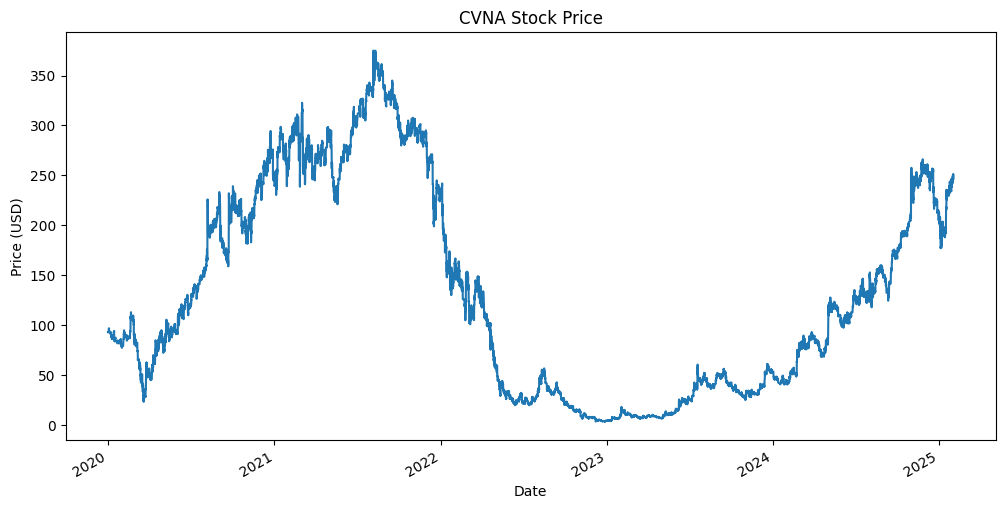

In [ ]:
plot_stock_price((dfs[tickers[0]]), tickers[0])

In [ ]:
index = 1
dfs[tickers[index]].shape, pca_dfs[tickers[index]].shape

((20170, 100), (20170, 10))

In [ ]:
dfs[tickers[index]].columns

Index(['close', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap', 'year',
       'month', 'day', 'hour', 'CELH_close', 'CELH_high', 'CELH_low',
       'CELH_trade_count', 'CELH_open', 'CELH_volume', 'CELH_vwap',
       'CELH_year', 'CELH_month', 'CELH_day', 'CELH_hour', 'KO_close',
       'KO_high', 'KO_low', 'KO_trade_count', 'KO_open', 'KO_volume',
       'KO_vwap', 'KO_year', 'KO_month', 'KO_day', 'KO_hour', 'SPY_close',
       'SPY_high', 'SPY_low', 'SPY_trade_count', 'SPY_open', 'SPY_volume',
       'SPY_vwap', 'SPY_year', 'SPY_month', 'SPY_day', 'SPY_hour', 'hour_sin',
       'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'time_embedding_0', 'time_embedding_1', 'time_embedding_2',
       'time_embedding_3', 'time_embedding_4', 'time_embedding_5',
       'time_embedding_6', 'time_embedding_7', 'CELH_hour_sin',
       'CELH_hour_cos', 'CELH_day_sin', 'CELH_day_cos', 'CELH_month_sin',
       'CELH_month_cos', 'CELH_time_embedding_0', 'CELH_time_embedding_1'

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.6 MB/s eta 0:00:00


In [ ]:
from pyts.image import GramianAngularField

def get_gaf(past_data, image_size = 16):

    gaf_transformer = GramianAngularField(image_size=image_size, method="difference")
    ts1, ts2, ts3 = past_data[0], past_data[1], past_data[2]
    # Convert each time series to GAF
    gaf1 = gaf_transformer.fit_transform(ts1.reshape(1, -1))[0]  # (64, 64)
    gaf2 = gaf_transformer.fit_transform(ts2.reshape(1, -1))[0]  # (64, 64)
    gaf3 = gaf_transformer.fit_transform(ts3.reshape(1, -1))[0]  # (64, 64)

    # Stack to create a 3-channel image
    gaf_image = np.stack([gaf1, gaf2, gaf3], axis=0)  # Shape: (3, 64, 64)
    return gaf_image

In [ ]:
import cv2
def resize_image(image, target_size=(224, 224)):

    target_H, target_W = target_size

    resized_channels = [cv2.resize(image[i], (target_W, target_H), interpolation=cv2.INTER_LINEAR) for i in range(3)]

    return np.stack(resized_channels, axis=0)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

# Load pre-trained ResNet50 and remove the FC layer
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Removes the FC layer
model.eval()

BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def extract_features_in_batches(data, batch_size):
    all_features = []

    for i in tqdm(range(0, len(data), batch_size), desc="Extracting Features"):
        batch = data[i : i + batch_size]

        batch_tensors = [torch.tensor(x, dtype=torch.float32) for x in batch]
        batch_tensors = torch.stack(batch_tensors).to(device)

        if batch_tensors.ndim == 3:  # If missing the channel dimension
            batch_tensors = batch_tensors.unsqueeze(1)  # Assume grayscale (1 channel)

        with torch.no_grad():
            features = model(batch_tensors)
            features = features.view(features.size(0), -1)  # Flatten features

        all_features.append(features.cpu())

    return torch.cat(all_features, dim=0)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


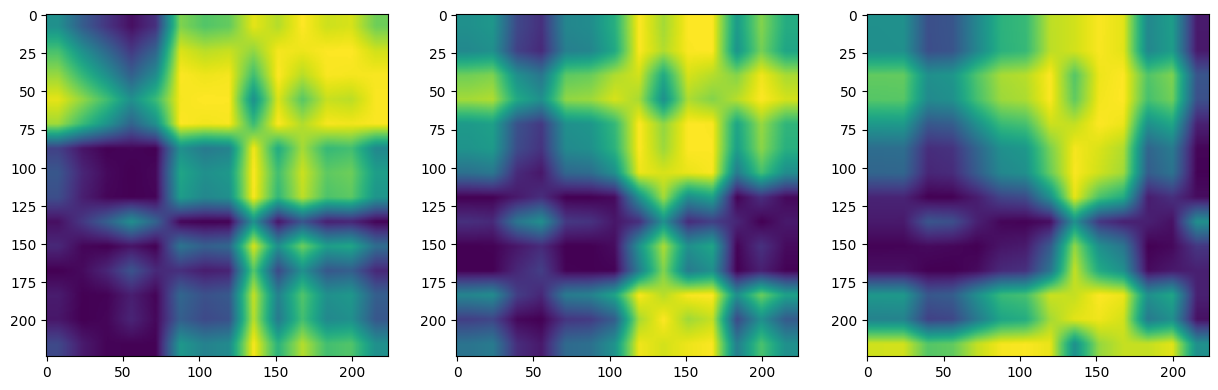

In [ ]:
#Plot gaf
import matplotlib.pyplot as plt
gaf = gafs_array2[100]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axs[i].imshow(gaf[i], cmap='viridis')

In [ ]:
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define classification thresholds (adjust based on market volatility)

window_size = 100
look_ahead = 1  # Predict price movement after 10 hours

index = 0

X, y = [], []

df = dfs[tickers[index]]

gafs_array1, gafs_array2, gafs_array3, gafs_array4 = [], [], [], []
for i in tqdm(range(len(df) - window_size - look_ahead)):
    past_data1, past_data2, past_data3, past_data4 = [], [], [], []
    for ticker in tickers_matchings[tickers[index]]:
        # print(ticker)|
        col1 = f"{ticker}_close"
        col2 = f"{ticker}_open"
        col3 = f"{ticker}_volume"
        high_col = f"{ticker}_high"
        low_col = f"{ticker}_low"

        past_data1.append(df.iloc[i:i + window_size, :][col1].values)
        past_data2.append(df.iloc[i:i + window_size, :][col2].values)
        past_data3.append(df.iloc[i:i + window_size, :][col3].values)
        #Difference between High and Low
        past_data4.append(df.iloc[i:i + window_size, :][high_col].values - df.iloc[i:i + window_size, :][low_col].values)


    past_data1 = np.array(past_data1)
    past_data2 = np.array(past_data2)
    past_data3 = np.array(past_data3)
    past_data4 = np.array(past_data4)

    gaf_array1 = resize_image(get_gaf(past_data1))
    gaf_array2 = resize_image(get_gaf(past_data2))
    gaf_array3 = resize_image(get_gaf(past_data3))
    gaf_array4 = resize_image(get_gaf(past_data4))

    gafs_array1.append(gaf_array1)
    gafs_array2.append(gaf_array2)
    gafs_array3.append(gaf_array3)
    gafs_array4.append(gaf_array4)

100%|██████████| 1177/1177 [00:15<00:00, 76.18it/s]


In [ ]:
gafs_array1 = np.array(gafs_array1)
gafs_array2 = np.array(gafs_array2)
gafs_array3 = np.array(gafs_array3)
gafs_array1.shape, gafs_array2.shape, gafs_array3.shape

((1177, 3, 224, 224), (1177, 3, 224, 224), (1177, 3, 224, 224))

In [ ]:
torch.cuda.is_available()

True

In [ ]:
BATCH_SIZE = 2
feature_vectors = extract_features_in_batches(gafs_array1, BATCH_SIZE)
feature_vectors = torch.cat((feature_vectors, extract_features_in_batches(gafs_array2, BATCH_SIZE)), dim=1)
feature_vectors = torch.cat((feature_vectors, extract_features_in_batches(gafs_array3, BATCH_SIZE)), dim=1)
feature_vectors = torch.cat((feature_vectors, extract_features_in_batches(gafs_array4, BATCH_SIZE)), dim=1)
feature_vectors.shape

Extracting Features: 100%|██████████| 589/589 [00:05<00:00, 115.84it/s]


torch.Size([1177, 8192])

In [ ]:
feature_vectors = feature_vectors.numpy()

In [ ]:
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from collections import Counter

# Define classification thresholds
threshold = 0.01  # 0.1% price change threshold for binary classification

window_size = 100
look_ahead = 1  # Predict price movement after 5 time steps

index = 0
X, y = [], []

df = dfs[tickers[index]]

# Feature extraction
for i in tqdm(range(len(df) - window_size - look_ahead)):
    feature_vector = feature_vectors[i]
    present_price = df.iloc[i + window_size]["close"]
    future_price = df.iloc[i + window_size + look_ahead]["close"]

    # Calculate price movement percentage
    price_change = (future_price - present_price) / present_price

    # Binary labels: 1 = Up, 0 = Down
    cur_label = 1 if price_change > threshold else 0

    X.append(feature_vector)
    y.append(cur_label)

X = np.array(X)
y = np.array(y)

# Flatten X
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape of X before PCA: {X_flat.shape}, Shape of y: {y.shape}")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Apply PCA
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)

print(f"Shape of X after PCA: {X_pca.shape}")

# Compute class imbalance ratio for XGBoost & LightGBM
counter = Counter(y)
num_neg = counter[0]
num_pos = counter[1]
scale_pos_weight = num_neg / num_pos
print(f"Computed scale_pos_weight: {scale_pos_weight:.2f}")

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.5,
    reg_lambda=2.0,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=2.0,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Define LightGBM model
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.5,
    reg_lambda=2.0,
    subsample=0.7,
    colsample_bytree=0.7
)

# Walk-forward validation function
def walk_forward_validation(X, y, models, test_size_ratio=0.2):
    test_size = int(len(X) * test_size_ratio)
    scores = {model_name: [] for model_name in models}

    for i in range(5):  # Five train-test splits
        train_end = len(X) - (test_size * (5 - i))
        X_train, y_train = X[:train_end], y[:train_end]
        X_test, y_test = X[train_end:], y[train_end:]

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            scores[model_name].append(acc)

    return {model: (np.mean(scores[model]), np.std(scores[model])) for model in scores}

# Run walk-forward validation on both models
models = {"XGBoost": xgb_model}
results = walk_forward_validation(X_pca, y, models)

# Print results
for model, (mean_acc, std_acc) in results.items():
    print(f"\n{model} Walk-Forward Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


100%|██████████| 1177/1177 [00:00<00:00, 3571.69it/s]


Shape of X before PCA: (1177, 8192), Shape of y: (1177,)
Shape of X after PCA: (1177, 915)
Computed scale_pos_weight: 1.58


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


XGBoost Walk-Forward Accuracy: 0.5602 ± 0.0279
